# **Philanthropy Gala Planning**

## Initial Data Exploring, Filtering, Analysis, and Chart Creation

This notebook processes IRS ZIP-code-level tax data to identify the most generous neighborhoods in the US during 2022, then visualizes results.

## Step 1: Data Processing & Filtering

### 1.1 Imports & Data Loading

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Load dataset
# We use 'noagi' since it contains pre-calculated totals for
# every ZIP code, making analysis faster on a national level.
df = pd.read_csv('data/original/22zpallnoagi.csv')
df.head()

,STATEFIPS,STATE,ZIPCODE,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,0,2116220.0,942190.0,743980.0,379550.0,1979060.0,64740.0,...,54890.0,223948.0,517250.0,2853174.0,1539200.0,5820514.0,1507110.0,4971630.0,36500.0,767916.0
1,1,AL,35004,0,5410.0,2460.0,2040.0,770.0,5090.0,150.0,...,60.0,89.0,1480.0,5019.0,3780.0,11161.0,3750.0,10548.0,60.0,178.0
2,1,AL,35005,0,3290.0,1580.0,740.0,890.0,3060.0,100.0,...,0.0,0.0,610.0,1471.0,2620.0,8106.0,2610.0,8094.0,0.0,0.0
3,1,AL,35006,0,1260.0,500.0,560.0,170.0,1200.0,30.0,...,0.0,0.0,290.0,815.0,930.0,2749.0,930.0,2623.0,0.0,0.0
4,1,AL,35007,0,12540.0,5470.0,4950.0,1780.0,11590.0,530.0,...,170.0,383.0,3770.0,13618.0,8400.0,23549.0,8300.0,22506.0,120.0,705.0


### 1.2 Data Sanitization

ZIP codes have a chance to be read as numbers, deleting leading zeros (ex. 08701 &rarr; 8701). We fix this and filter dataset to neighborhood-level summary rows, excluding state and other totals.

In [15]:
# Ensure ZIP codes are valid 5-digit strings
df['ZIPCODE'] = df['ZIPCODE'].astype(str).str.zfill(5)

# agi_stub 0 = summary row for entire ZIP code.
# Remove '00000' (state totals) and '99999' (other) to focus on neighborhoods.
neighborhoods = df[(df['agi_stub'] == 0) & (~df['ZIPCODE'].isin(['00000', '99999']))].copy()
print(f"Neighborhood-level rows: {len(neighborhoods):,}")

Neighborhood-level rows: 27,588


### 1.3 Calculate Proprietary Metrics

- **Generosity Index (GI):** Charity donations (A19700) as a share of total income (A00100)
    - We consider this the neighborhood's "sacrifice ratio."
- **Participation Rate (PR):** Count of donors (N19700) vs. total households (N1)
    - This tells us how ingrained giving is in the community.

In [16]:
neighborhoods['generosity_index'] = neighborhoods['A19700'] / neighborhoods['A00100']
neighborhoods['participation_rate'] = neighborhoods['N19700'] / neighborhoods['N1']
neighborhoods[['ZIPCODE', 'STATE', 'generosity_index', 'participation_rate']].head()

,ZIPCODE,STATE,generosity_index,participation_rate
1,35004,AL,0.011223,0.060998
2,35005,AL,0.009865,0.042553
3,35006,AL,0.004228,0.023810
4,35007,AL,0.011716,0.064593
5,35010,AL,0.013951,0.050000


### 1.4 Reliability Filter & Export

We ignore ZIP codes with fewer than 500 households so our strategy is based on community behavior, not outliers. The final list is sorted by Generosity Index and exported.

In [17]:
filtered_targets = neighborhoods[neighborhoods['N1'] >= 500].copy()
final_list = filtered_targets.sort_values(by='generosity_index', ascending=False)

final_list.to_csv('data/updated_gala_list.csv', index=False)
print(f"Dataset filtered and created — {len(final_list):,} ZIP codes exported to 'data/updated_gala_list.csv'.")
final_list.head(10)

Dataset filtered and created — 21,761 ZIP codes exported to 'data/updated_gala_list.csv'.


,STATEFIPS,STATE,ZIPCODE,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,generosity_index,participation_rate
2283,6,CA,94304,0,1940.0,1010.0,770.0,80.0,1810.0,90.0,...,730.0,46812.0,1180.0,268527.0,940.0,13511.0,290.0,121171.0,0.246632,0.252577
16093,36,NY,10952,0,12690.0,3440.0,8220.0,790.0,12080.0,270.0,...,2790.0,27343.0,9510.0,116066.0,8880.0,67457.0,820.0,48524.0,0.179621,0.170213
1312,5,AR,72712,0,17520.0,8270.0,7390.0,1480.0,16650.0,470.0,...,5470.0,50890.0,11610.0,319639.0,11190.0,39064.0,530.0,280553.0,0.173215,0.110160
25418,51,VA,23219,0,2790.0,2350.0,220.0,180.0,2640.0,50.0,...,660.0,2700.0,2070.0,120715.0,2010.0,42515.0,50.0,78147.0,0.158613,0.046595
16245,36,NY,11559,0,3710.0,1700.0,1610.0,270.0,3430.0,120.0,...,1180.0,17779.0,2320.0,117105.0,1690.0,26912.0,770.0,90276.0,0.131753,0.307278
19788,40,OK,74119,0,1920.0,1420.0,320.0,120.0,1740.0,80.0,...,540.0,3973.0,1280.0,26248.0,1200.0,3014.0,110.0,23193.0,0.111404,0.078125
15628,34,NJ,08701,0,36510.0,13010.0,20510.0,2530.0,34030.0,1300.0,...,8580.0,60384.0,26450.0,205538.0,24830.0,136915.0,2040.0,67685.0,0.106992,0.133662
16146,36,NY,11204,0,34050.0,15680.0,13660.0,3990.0,31990.0,1230.0,...,9590.0,43569.0,22330.0,119741.0,21620.0,81031.0,810.0,38674.0,0.105218,0.058443
16161,36,NY,11219,0,33870.0,13900.0,15980.0,3510.0,31650.0,1240.0,...,8120.0,33800.0,23880.0,132902.0,23240.0,98771.0,810.0,34132.0,0.096925,0.051078
16152,36,NY,11210,0,28440.0,14540.0,6230.0,6820.0,26850.0,770.0,...,6930.0,38985.0,20580.0,164306.0,19830.0,77768.0,930.0,85883.0,0.090363,0.124473


## Step 2: Visualization & Insight

### 2.1 Chart Setup

In [18]:
sns.set_theme(style="whitegrid")

### 2.2 The "Whale" Chart | Top 10 Bar Chart

Shows generousity leaders, the absolute best ZIP codes to target for our gala.

Visual saved: 'images/generosity_rankings.png'.


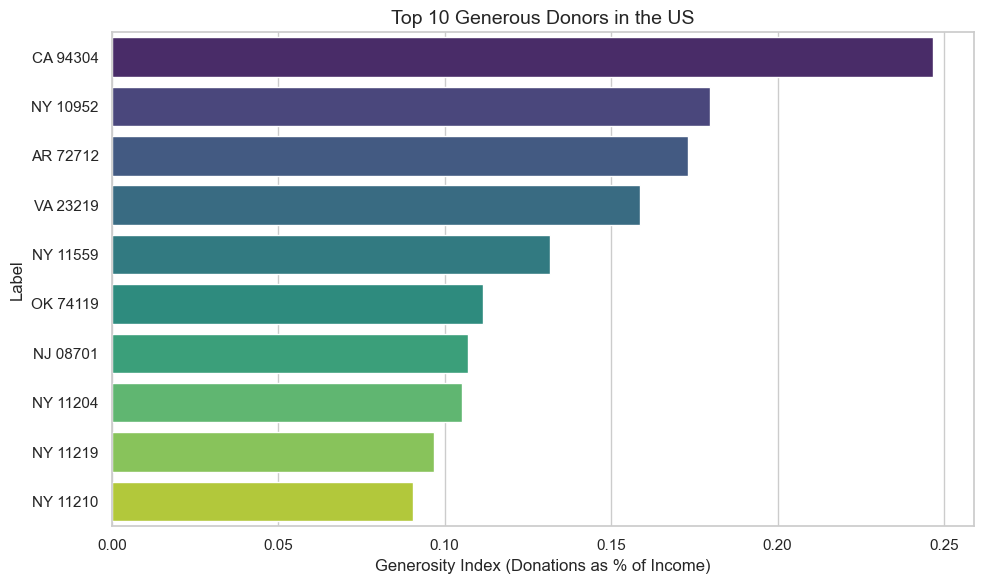

In [19]:
top_10 = final_list.head(10).copy()
top_10['Label'] = top_10['STATE'] + " " + top_10['ZIPCODE'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, x='generosity_index', y='Label', palette='viridis')
plt.title('Top 10 Generous Donors in the US', fontsize=14)
plt.xlabel('Generosity Index (Donations as % of Income)', fontsize=12)
plt.tight_layout()
plt.savefig('images/generosity_rankings.png')
print("Visual saved: 'images/generosity_rankings.png'.")
plt.show()

### 2.3 The "Hidden Gems" | Market Map Scatter Plot

Finds "Hidden Gem" neighborhoods with high generosity but moderate income. We focus on areas earning < $500k to see cluster clearly.

Visual saved: 'images/hidden_gems_map.png'.


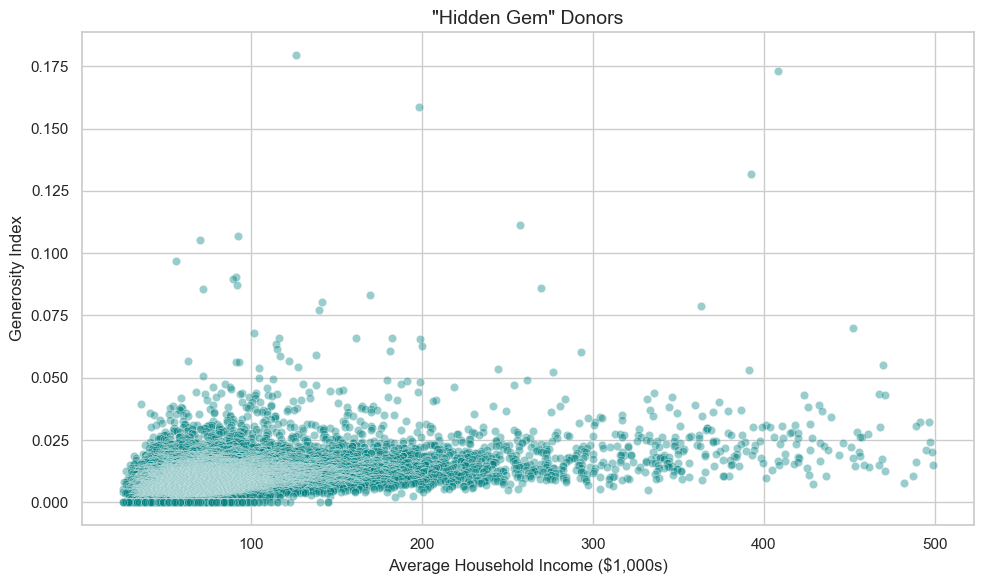

In [20]:
final_list['avg_income_k'] = final_list['A00100'] / final_list['N1']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_list[final_list['avg_income_k'] < 500], x='avg_income_k', y='generosity_index', alpha=0.4, color='teal')
plt.title('"Hidden Gem" Donors', fontsize=14)
plt.xlabel('Average Household Income ($1,000s)', fontsize=12)
plt.ylabel('Generosity Index', fontsize=12)
plt.tight_layout()
plt.savefig('images/hidden_gems_map.png')
print("Visual saved: 'images/hidden_gems_map.png'.")
plt.show()

### 2.4 Participation vs. Generosity Bubble Chart | Top 200

Combines both proprietary metrics into one view. Each bubble is a ZIP code, its position shows generosity and participation, while its size reflects household count.

Visual saved: 'images/gala_targets.png'.


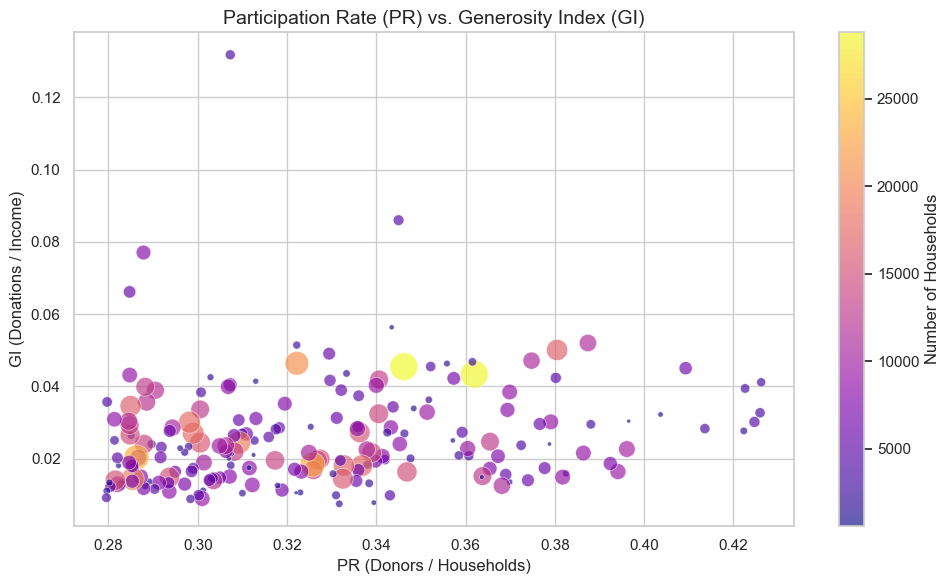

In [27]:
# Focus on top 200 to keep chart readable
top_pr = final_list.sort_values(by='participation_rate', ascending=False).head(200).copy()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    top_pr['participation_rate'],
    top_pr['generosity_index'],
    s=(top_pr['N1'] / top_pr['N1'].max()) * 400,
    c=top_pr['N1'],
    cmap='plasma',
    alpha=0.65,
    edgecolors='white',
    linewidth=0.5
)
plt.colorbar(scatter, label='Number of Households')
plt.title('Participation Rate (PR) vs. Generosity Index (GI)', fontsize=14)
plt.xlabel('PR (Donors / Households)', fontsize=12)
plt.ylabel('GI (Donations / Income)', fontsize=12)
plt.tight_layout()
plt.savefig('images/gala_targets.png')
print("Visual saved: 'images/gala_targets.png'.")
plt.show()